In [243]:
import os,sys
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline

# Загрузим данные
 * При первом запуске скачаем train.csv и evaluation.csv
 * При повторных запусках файлы уже будут на месте

In [244]:
evaluation_url = "https://www.dropbox.com/s/4y54q61b6s18ofh/train.csv?dl=1"
training_url = "https://www.dropbox.com/s/482zjl1hzgvej92/test.csv?dl=1"
evaluation_path = "evaluation.handout.csv"
training_path = "train.csv"

if sys.version_info[0] == 2:
    from urllib import urlretrieve
else:
    from urllib.request import urlretrieve

if not os.path.exists(evaluation_path):
    urlretrieve(evaluation_url,evaluation_path)
if not os.path.exists(training_path):
    urlretrieve(training_url,training_path)

In [245]:
data = pd.DataFrame.from_csv("./train.csv")

In [246]:
#Если у вас слабый компьютер - можно взять подвыборку данных
#data = data[::2]

# Добавим новые фичи : zone и num_in_area

In [247]:
data = data[::1000]

In [248]:
x_col = [ 'dist','due', 'lat','lon','f_class','s_class','t_class',]
X_raw = data[x_col]
y = data['burned'].values

In [249]:
from dateutil import parser
import datetime

In [250]:
times = X_raw['due']

In [251]:
times = list(X_raw.due.apply(lambda x: parser.parse(x)))

In [252]:
def fn_tm(tm, times):
    time_0 = times[0]
    num = 0
    arr = []
    for time in times:
        if (time - time_0).seconds <= tm * 60 or (time - time_0).days < 0:
            arr.append(num)
        else:
            num += 1
            time_0 = time
            arr.append(num)
    return arr

In [253]:
X_raw['zone'] = fn_tm(60, times)

/home/trakhov/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [254]:
max_zone = X_raw.iloc[X_raw.shape[0] - 1 , X_raw.shape[1] - 1]

In [255]:
def count_of_order():
    arr = []
    for i in range(max_zone + 1):
        for j in range(X_raw[X_raw['zone'] == i].shape[0]):
            num = 0
            for k in range(X_raw[X_raw['zone'] == i].shape[0]):
                if (X_raw[X_raw['zone'] == i].iloc[j,2] - X_raw[X_raw['zone'] == i].iloc[k,2])**2 < 0.01 and (X_raw[X_raw['zone'] == i].iloc[j,3] - X_raw[X_raw['zone'] == i].iloc[k,3])**2 < 0.01 :            
                    num += 1
            arr.append(num)
    return arr

In [256]:
X_raw["num_in_area"] = count_of_order() 

/home/trakhov/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


# Простое решение
- Сделаем One-Hot encoding для всех категориальных фичей
- Научим Random Forest

### Предобработка данных

In [257]:
from sklearn.feature_extraction import DictVectorizer

#вытаскиватель категориальных фичей
vectorizer = DictVectorizer(sparse=False,dtype=np.bool)

def preprocess_data(X_raw):
    data_dict = [ {'f_class':f,'s_class':s,'t_class':t}
               for f,s,t in X_raw[['f_class','s_class','t_class']].values ]

    Xcat = vectorizer.fit_transform(data_dict)
    
    real_features = ["dist","lat","lon","num_in_area"]
    Xreal = X_raw[real_features].values
    Xfull = np.concatenate([
            Xreal,
            Xcat            
        ],axis=1)
    
    return pd.DataFrame(Xfull,columns=real_features+vectorizer.feature_names_)

In [258]:
X = preprocess_data(X_raw)

### Поделим на обучение и валидацию
* Важно, что мы делим не случайно, а по времени:
 * Валидационная выборка вся находится строго раньше тестовой
 * Это вызвано тем, что тестовые данные по времени дальше обучающих

In [259]:
#обучение и тест
pivot = int(len(X) * 0.75)
Xtr = X[:pivot]
Xval = X[pivot:]
Ytr = y[:pivot]
Yval = y[pivot:]

### Обучим модель

In [260]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=250,n_jobs=-1)
model.fit(Xtr,Ytr)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=250, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

# Оценим качество

Посчитаем AUC и Accuracy@10k на обучении и тесте

train: 	 AUC = 1.00000 	 Accuracy = 0.17770
val: 	 AUC = 0.62790 	 Accuracy = 0.15813


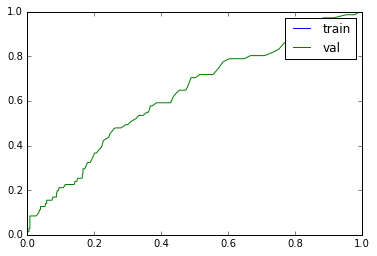

In [263]:
from sklearn.metrics import roc_auc_score,accuracy_score,precision_score,recall_score
from sklearn.metrics import roc_curve


for source_i, Xi,Yi in [
                            ["train",Xtr,Ytr],
                            ["val",Xval,Yval]
                                ]:
    
    # Предскажем вероятность сгорания
    Yi_pred_proba = model.predict_proba(Xi)[:,1]
    
    #Поделим предсказание на сгоревшие и не сгоревшие
    Yi_pred_class = np.argsort(Yi_pred_proba) < 10000
    
    auc = roc_auc_score(Yi,Yi_pred_proba)
    acc = accuracy_score(Yi,Yi_pred_class)
    
    print '%s: \t AUC = %.5f \t Accuracy = %.5f'%(source_i, auc, acc)
    
    fpr,tpr,_ = roc_curve(Yi,Yi_pred_proba)
    
    plt.plot(fpr,tpr,label = source_i)
    
plt.legend()


In [264]:
auc

0.62789701169982859

# Отгрузим решение в файл

In [265]:
def write_answer(auc):
    with open("answer.txt", "w") as fout:
        fout.write(str(auc))

In [266]:
write_answer(auc)